In [1]:
import numpy as np
import pulp
import itertools
# import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
from scipy.linalg import block_diag

C:\Users\DELL\AppData\Roaming\Python\Python38\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preparation

In [2]:
graph_3f_edges = pd.read_csv("./3F/DATA-SHU 240 Data Representation - Sheet1.csv")
graph_3f_weights = pd.read_csv("./3F/DATA-SHU 240 Data Representation - Sheet2.csv")
graph_3f_node_grid = pd.read_csv("./3F/DATA-SHU 240 Data Representation - Sheet3.csv")

graph_1f_edges = pd.read_csv("./1F/DATA-SHU 240 Data Representation - Sheet4.csv")
graph_1f_weights = pd.read_csv("./1F/DATA-SHU 240 Data Representation - Sheet5.csv")
graph_1f_node_grid = pd.read_csv("./1F/DATA-SHU 240 Data Representation - Sheet6.csv")

In [3]:
G1 = nx.Graph()
G3 = nx.Graph()
for i in graph_1f_weights.index:
    G1.add_node(graph_1f_weights['node'][i], weight=graph_1f_weights['weight'][i], pos=(graph_1f_node_grid['coordinate_x'][i],graph_1f_node_grid['coordinate_y'][i]))
for i in graph_3f_weights.index:
    G3.add_node(graph_3f_weights['node'][i], weight=graph_3f_weights['weight'][i], pos=(graph_3f_node_grid['coordinate_x'][i],graph_3f_node_grid['coordinate_y'][i]))
for i in graph_1f_edges.index:
    G1.add_edge(graph_1f_edges['edge_from'][i], graph_1f_edges['edge_to'][i], weight=graph_1f_edges['weight'][i])
for i in graph_3f_edges.index:
    G3.add_edge(graph_3f_edges['edge_from'][i], graph_3f_edges['edge_to'][i], weight=graph_3f_edges['weight'][i])

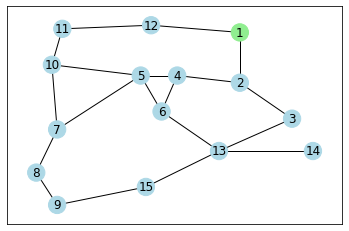

In [4]:
color_map = ["lightgreen"] + ["lightblue" for i in range(len(G1.nodes)-1)]
nx.draw_networkx(G1, with_labels=True, pos = nx.get_node_attributes(G1,'pos'), node_color = color_map)

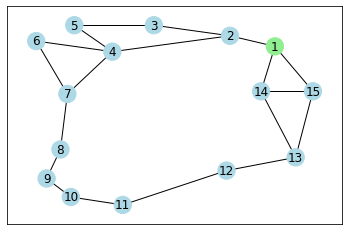

In [5]:
nx.draw_networkx(G3, with_labels=True, pos = nx.get_node_attributes(G3,'pos'),node_color = color_map)

# Model Formulation

## Single Floor Planner

Maximum weights:  31.0


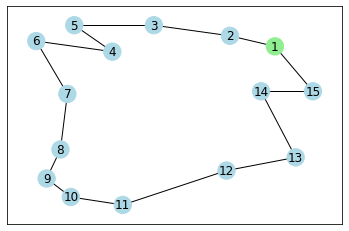

In [13]:
# solve with pulp
# definition of LpProblem instance
def compute_num_of_sites(G):
    return len(G.nodes())

def generate_adjacency_matrix(G):
        num_of_sites = compute_num_of_sites(G)
        adjacency_matrix = np.zeros((num_of_sites, num_of_sites))
        for (edge_from, edge_to), weight in nx.get_edge_attributes(G, "weight").items():
            adjacency_matrix[edge_from-1][edge_to-1] = 1
            adjacency_matrix[edge_to-1][edge_from-1] = 1
        return adjacency_matrix
    
def generate_cost_matrix(G):
    num_of_sites = compute_num_of_sites(G)
    cost_matrix = np.zeros((num_of_sites, num_of_sites))
    for (edge_from, edge_to), weight in nx.get_edge_attributes(G, "weight").items():
        cost_matrix[edge_from-1][edge_to-1] = weight
        cost_matrix[edge_to-1][edge_from-1] = weight
    return cost_matrix

def floor_routing_solver(G, time_limit):

    num_of_sites = compute_num_of_sites(G)
    
    cost_matrix = generate_cost_matrix(G)
    
    adjacency_matrix = generate_adjacency_matrix(G)
    
    problem = pulp.LpProblem("CVRP", pulp.LpMaximize)
    
    node_weights = list(nx.get_node_attributes(G1,"weight").values())

    # definition of binary variables
    x = [[pulp.LpVariable("x%s_%s"%(i,j), cat="Binary") if i != j else None for j in range(num_of_sites)] for i in range(num_of_sites)]
    y = np.array(x)
    t = pulp.LpVariable.dicts("t", (i for i in range(num_of_sites)), lowBound=0, upBound=time_limit, cat='Continuous')

    # add objective function
    problem += pulp.lpSum((node_weights[i] + node_weights[j]) * y[i][j] / 2 if i != j else 0
                            for j in range(num_of_sites) 
                            for i in range(num_of_sites))

    # constraints
    # Constraint 1: Visit less than Once
    for j in range(num_of_sites):
        problem += pulp.lpSum(y[i][j] if i != j else 0 
                                for i in range(num_of_sites)) <= 1 

    # Constraint 2: Must Depart from the Depot
    problem += pulp.lpSum(y[0][j] for j in range(1,num_of_sites)) == 1
    # problem += pulp.lpSum(y[i][0] for i in range(1,num_of_sites)) == 1


    # Constraint 3: Degree Match
    for j in range(1, num_of_sites):
        problem += pulp.lpSum(y[i][j] if i != j else 0 for i in range(num_of_sites)) \
                            - pulp.lpSum(x[j][i] if i != j else 0 for i in range(num_of_sites)) \
                            == 0
    
    # Constraint 4: No Shuttle Run
    for i in range(num_of_sites):
        for j in range(num_of_sites):
            if i < j:
                problem += (y[i][j] + y[j][i]) <= 1

    # Constraint 5: time constraint
    problem += pulp.lpSum(cost_matrix[i][j] * x[i][j] if i != j else 0 for i in range(num_of_sites) 
                          for j in range (num_of_sites)) <= time_limit 


    # Constraint 6: pass through edges that exist
    for i in range(num_of_sites):
        for j in range(num_of_sites):
            if i != j:
                problem += (y[i][j] <= int(adjacency_matrix[i][j])) 


    # Constraint 7: remove subtours
    for i in range(1, num_of_sites):
        for j in range(1, num_of_sites):
            if i != j and (i != 0 and j != 0):
                problem += t[j] >= t[i] + cost_matrix[i][j] * y[i][j] - time_limit * (1 - y[i][j])


    if problem.solve() == 1:
        print('Maximum weights: ', pulp.value(problem.objective))
        
    varValues = np.zeros((num_of_sites, num_of_sites))
    for i in range(len(y)):
        for j in range(len(y[i])):
            if y[i][j] != None:
                varValues[i][j] = y[i][j].varValue
    
    return varValues

# visualize the result
def visualize_the_routing(G, varValues):
    NG = nx.Graph()
    node_weights = nx.get_node_attributes(G,"weight")
    node_pos = nx.get_node_attributes(G,"pos")
    for node in G.nodes():
        NG.add_node(node, weight=node_weights[node] 
                    ,pos=(node_pos[node][0],node_pos[node][0]))

    for i in range(len(varValues)):
        for j in range(len(varValues)):
            if varValues[i][j]==1:
                if varValues[i][j] ==  varValues[j][i] == 1: 
                    NG.add_edge(i + 1, j + 1, color="r")
                else:
                    NG.add_edge(i + 1, j + 1, color="black")

    colors = [NG[u][v]['color'] for u,v in NG.edges]
    ncolors = ["lightgreen"] + ["lightblue" for i in range(len(NG.nodes)-1)]
    nx.draw_networkx(NG, with_labels=True, pos = nx.get_node_attributes(G,'pos'), edge_color=colors, node_color = ncolors)
        
varValues = floor_routing_solver(G3, 200)

visualize_the_routing(G3, varValues)

## Multi-Floor Planner

Time Limit 1000
Maximum weights:  55.0


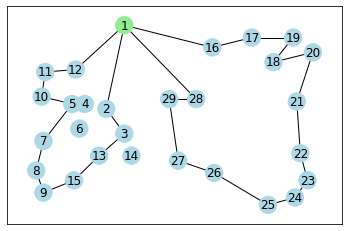

In [16]:
class MultiFloorSolver:
    
    # Assume to be two graphs, sharing one depot node
    def __init__(self, G_list, time_limit):
        self.G_list = G_list
        self.time_limit = time_limit
        self.compute_concated_num_of_sites()
        self.construct_concated_node_weights()
        self.construct_concated_adjacency_matrix()
        self.construct_concated_cost_matrix()
    
    def compute_concated_num_of_sites(self):
        self.concated_num_of_sites = 0
        for G in self.G_list:
            self.concated_num_of_sites += self.compute_num_of_sites(G)
        self.concated_num_of_sites -= (len(self.G_list) - 1)
  
    def construct_concated_node_weights(self):
        temp = np.array([[1]])
        for G in self.G_list:
            temp = np.hstack([temp, self.compute_node_weigths(G)])
        self.node_weights = temp.squeeze()

    def construct_concated_adjacency_matrix(self):
        A = np.array([[0]])
        B = np.array([[0]])
        C = np.array([[0]])
        D = np.array([[0]])
        for G in self.G_list:
            adj_temp = self.construct_adjacency_matrix(G)
            B = np.hstack([B, adj_temp[0, 1:].reshape(1,-1)])
            C = np.vstack([C, adj_temp[1:,0].reshape(-1,1)])
            D = block_diag(D, adj_temp[1:, 1:])
        B = B[0, 1:].reshape(1,-1)
        C = C[1:,0].reshape(-1,1)
        D = D[1:, 1:]
    
        adj_concated = np.vstack([np.hstack([A,B]), np.hstack([C,D])])
        self.adj_matrix = adj_concated
    
    def construct_concated_cost_matrix(self):
        A = np.array([[0]])
        B = np.array([[0]])
        C = np.array([[0]])
        D = np.array([[0]])
        for G in self.G_list:
            adj_temp = self.construct_cost_matrix(G)
            B = np.hstack([B, adj_temp[0, 1:].reshape(1,-1)])
            C = np.vstack([C, adj_temp[1:,0].reshape(-1,1)])
            D = block_diag(D, adj_temp[1:, 1:])
        B = B[0, 1:].reshape(1,-1)
        C = C[1:,0].reshape(-1,1)
        D = D[1:, 1:]
    
        adj_concated = np.vstack([np.hstack([A,B]), np.hstack([C,D])])
        self.cost_matrix = adj_concated   
        
    def compute_num_of_sites(self, G):
        return len(G.nodes())
    
    def compute_node_weigths(self, G):
        return np.array(list(nx.get_node_attributes(G,"weight").values())[1:]).reshape(1,-1)
    
    def construct_adjacency_matrix(self, G):
        num_of_sites = compute_num_of_sites(G)
        adjacency_matrix = np.zeros((num_of_sites, num_of_sites))
        for (edge_from, edge_to), weight in nx.get_edge_attributes(G, "weight").items():
            adjacency_matrix[edge_from-1][edge_to-1] = 1
            adjacency_matrix[edge_to-1][edge_from-1] = 1
        return adjacency_matrix
    
    def construct_cost_matrix(self, G):
        num_of_sites = compute_num_of_sites(G)
        cost_matrix = np.zeros((num_of_sites, num_of_sites))
        for (edge_from, edge_to), weight in nx.get_edge_attributes(G, "weight").items():
            cost_matrix[edge_from-1][edge_to-1] = weight
            cost_matrix[edge_to-1][edge_from-1] = weight
        return cost_matrix
    
    # Two Graph Case
    def construct_concated_graph(self, option):
        NG = nx.Graph()
        if len(self.G_list) <= 2:
            G1 = self.G_list[0] # 1F Floor
            G2 = self.G_list[1] # 3F Floor
            
            # Node Information
            pos_dict_1 = nx.get_node_attributes(G1, "pos")
            pos_dict_2 = nx.get_node_attributes(G2, "pos")
            weights_dict_1 = nx.get_node_attributes(G1, "weight")
            weights_dict_2 = nx.get_node_attributes(G2, "weight")
            
            # Edge Information
            edge_weights_dict_1 = nx.get_edge_attributes(G1, "weight")
            edge_weights_dict_2 = nx.get_edge_attributes(G2, "weight")
            
            flag = True
            # Constructing nodes
            for node in G1:
                if flag:
                    NG.add_node(node, weight=weights_dict_1[node], pos=pos_dict_1[node])
                    flag = False
                else:
                    # Add nodes from graph 1
                    NG.add_node(node, weight=weights_dict_1[node], pos=(pos_dict_1[node][0] - 1, pos_dict_1[node][1]-2))
            flag = True
            for node in G2:
                if flag:
                    flag = False
                else:
                    # Add nodes from graph 2, with coordinate_x all drifted(except the common depot), have to flip it
                    NG.add_node(node + len(G1.nodes()) - 1, weight=weights_dict_1[node], pos=(2 * pos_dict_1[1][0] - pos_dict_2[node][0] + 6, pos_dict_2[node][1] - 2))
            
            
            if option == "full":
                # Constructing Edges
                for (edge_from, edge_to), weight in nx.get_edge_attributes(G1, "weight").items():
                    NG.add_edge(edge_from, edge_to, weight=weight)


                for (edge_from, edge_to), weight in nx.get_edge_attributes(G2, "weight").items():
                    if edge_from == 1: 
                        NG.add_edge(edge_from, edge_to + len(G1.nodes) - 1, weight=weight)
                    elif edge_to == 1:
                        NG.add_edge(edge_from + len(G1.nodes) - 1, edge_to, weight=weight)
                    else:
                        NG.add_edge(edge_from + len(G1.nodes) - 1, edge_to + len(G1.nodes) - 1, weight=weight)
            
            return NG
            
        else:
            # Future Work
            pass
        
    # Two graph case
    def visualize_graph(self, G):
        if len(self.G_list) <= 2:
            color_map = ["lightgreen"] + ["lightblue" for i in range(self.concated_num_of_sites-1)]
            nx.draw_networkx(G, with_labels=True, pos = nx.get_node_attributes(G,'pos'), node_color = color_map)

        else:
            # Future Work
            pass

    def visualize_routing_results(self, varValues):   
        NG = self.construct_concated_graph(option="else")
            
        for i in range(len(varValues)):
            for j in range(len(varValues)):
                if varValues[i][j]==1:
                    if varValues[i][j] ==  varValues[j][i] == 1: 
                        NG.add_edge(i + 1, j + 1, color="r")
                    else:
                        NG.add_edge(i + 1, j + 1, color="black")

        colors = [NG[u][v]['color'] for u,v in NG.edges]
        color_map = ["lightgreen"] + ["lightblue" for i in range(self.concated_num_of_sites-1)]
        nx.draw_networkx(NG, with_labels=True, pos = nx.get_node_attributes(NG,'pos'), edge_color=colors,  node_color = color_map)

        
    def floor_routing_solver(self):
        print("Time Limit", self.time_limit)
        
        problem = pulp.LpProblem("CVRP", pulp.LpMaximize)

        # definition of binary variables
        x = [[pulp.LpVariable("x%s_%s"%(i,j), cat="Binary") if i != j else None 
                                      for j in range(self.concated_num_of_sites)] 
                                      for i in range(self.concated_num_of_sites)]
        t = pulp.LpVariable.dicts("t", (i for i in range(self.concated_num_of_sites))
                                      , lowBound=0
                                      , upBound=self.time_limit
                                      , cat='Continuous')

        # add objective function
        problem += pulp.lpSum((self.node_weights[i] + self.node_weights[j]) * x[i][j] / 2 if i != j else 0
                                for j in range(self.concated_num_of_sites) 
                                for i in range(self.concated_num_of_sites))

        # constraints
        # Constraint 1: Visit less than Once
        for j in range(1,self.concated_num_of_sites):
            problem += pulp.lpSum(x[i][j] if i != j else 0 
                                    for i in range(self.concated_num_of_sites)) <= 1 

        # Constraint 2: Must Depart from the Depot
        problem += pulp.lpSum(x[0][j] for j in range(1,self.concated_num_of_sites)) >= 1

        # Constraint 3: Degree Match
        for i in range(self.concated_num_of_sites):
            for j in range(self.concated_num_of_sites):
                if i < j:
                    problem += (x[i][j] + x[j][i]) <= 1



        # Constraint 4: No Shuttle Run
        for j in range(1, self.concated_num_of_sites):
            problem += pulp.lpSum(x[i][j] if i != j else 0 
                                              for i in range(self.concated_num_of_sites)) \
                                - pulp.lpSum(x[j][i] if i != j else 0 
                                              for i in range(self.concated_num_of_sites)) \
                                == 0

        # Constraint 5: time constraint
        problem += pulp.lpSum(self.cost_matrix[i][j] * x[i][j] if i != j else 0 
                              for i in range(self.concated_num_of_sites) 
                              for j in range (self.concated_num_of_sites)) <= self.time_limit 


        # Constraint 6: pass through edges that exist
        for i in range(self.concated_num_of_sites):
            for j in range(self.concated_num_of_sites):
                if i != j:
                    problem += (x[i][j] <= int(self.adj_matrix[i][j])) 


        # Constraint 7: remove subtours
        for i in range(1, self.concated_num_of_sites):
            for j in range(1, self.concated_num_of_sites):
                if i != j and (i != 0 and j != 0):
                    problem += t[j] >= t[i] + self.cost_matrix[i][j] * x[i][j] - self.time_limit * (1 - x[i][j])


        if problem.solve() == 1:
            print('Maximum weights: ', pulp.value(problem.objective))

        varValues = np.zeros((self.concated_num_of_sites, self.concated_num_of_sites))
        for i in range(len(x)):
            for j in range(len(x[i])):
                if x[i][j] != None:
                    varValues[i][j] = x[i][j].varValue

        self.varValues = varValues
        return varValues

T = 1000
solverObject = MultiFloorSolver([G1,G3], T)    
varValues = solverObject.floor_routing_solver()
solverObject.visualize_routing_results(varValues)